# Components NGMS icon

In [5]:
import sys
sys.path.append('/work/mh0731/m300876/package/')
import icons
import intake
import matplotlib.pyplot as plt
import healpy as hp
import xarray as xr
import numpy as np
import easygems.healpix as egh
import seaborn as sns

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [6]:
icons.prepare_cpu(memory='100GB')

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/m300876/levante-spawner-advanced//proxy/42241/status,
Dashboard: /user/m300876/levante-spawner-advanced//proxy/42241/status,Workers: 1
Total threads: 256,Total memory: 93.13 GiB
Status: running,Using processes: False
Comm: inproc://136.172.120.71/2444480/1,Workers: 1
Dashboard: /user/m300876/levante-spawner-advanced//proxy/42241/status,Total threads: 256
Started: Just now,Total memory: 93.13 GiB
Comm: inproc://136.172.120.71/2444480/4,Total threads: 256
Dashboard: /user/m300876/levante-spawner-advanced//proxy/45869/status,Memory: 93.13 GiB
Nanny: None,


### Predefined functions

In [7]:
#### componenets of NGMS
g = 9.81
cp = 1005 ## J kg-1 K-1
Lv = 2500.93e3

### Calculate omega 
def calc_evapor(ds):
    epsilon = 0.622 #ratio of molar masses of vapor and dry air (0.622)
    return (ds.hus*ds.pressure)/(epsilon + (1-epsilon)*ds.hus)

def calc_pdry(ds):
    return ds.pressure - calc_evapor(ds)

def calc_density(ds):
    Md = 0.0289652  #molar mass of dry air, 0.0289652 kg/mol
    Mv = 0.018016 # molar mass of water vapor, 0.018016 kg/mol
    R = 8.31446 # universal gas constant, 8.31446 J/(K·mol)
    return (calc_pdry(ds)*Md + calc_evapor(ds)*Mv)/(R*ds.ta)

def calc_omega(ds):
    return -calc_density(ds)*ds.wa*g

### Energy components
def calc_mse(ds):
    cv = 719 ## J kg-1 K-1
    Lf = 334e3
    return cp*ds.ta + Lv*ds.hus + g*ds.zg

def calc_dhdz(ds):
    mse = calc_mse(ds) 
    return mse.differentiate(coord='pressure')

def calc_int_wdhdz(ds):
    return (calc_omega(ds)*calc_dhdz(ds)/g).integrate(coord='pressure')

def calc_mseflux(ds):
    return calc_mse(ds)*ds.ua, calc_mse(ds)*ds.va

def calc_int_mseflux(ds):
    umseflux,vmseflux =  calc_mseflux(ds)
    return (umseflux/g).integrate(coord='pressure').compute(), (vmseflux/g).integrate(coord='pressure').compute()

### Water components

def calc_qflux(ds):
    return ds.hus*ds.ua, ds.hus*ds.va

def calc_int_qflux(ds):
    uqflux,vqflux =  calc_qflux(ds)
    return (uqflux/g).integrate(coord='pressure').compute(), (vqflux/g).integrate(coord='pressure').compute()

In [8]:
### derivates in healpix

def nest2ring_index(ds):
    nside= hp.npix2nside(ds.cell.size)
    return np.array([hp.ring2nest(nside, i) for i in ds.cell.values])

def compute_hder(ds, ring_index):
    """computes the horizontal derivatives of any variable (1 vertical level, 1 time) using spherical harmonics"""
    nside= hp.npix2nside(ds.cell.size)
    var_alm = hp.sphtfunc.map2alm(ds.sel(cell = ring_index).values)
    der_arr = hp.sphtfunc.alm2map_der1(var_alm, nside)
    return der_arr[1, :]*-1, der_arr[2, :] # dvar_dtheta (co-lat), dvar_dphi (lon)

def convert2hp(narray,ds):
    nested_array = hp.reorder(narray,inp='RING',out='NESTED',r2n=True)
    xarray_hp = xr.DataArray(nested_array,dims=["cell"],
        coords=dict(
        lon=(["cell"], ds.lon.values),
        lat=(["cell"], ds.lat.values),
        ),)
    return xarray_hp

def compute_derivatives(ds):
    ring_index = nest2ring_index(ds)
    vardy,vardx = compute_hder(ds, ring_index)
    dsdx = convert2hp(vardx,ds)
    dsdy = convert2hp(vardy,ds)
    return dsdx,dsdy

def compute_flux_div(uflux, vflux):
    ring_index = nest2ring_index(uflux)
    _, dua_dphi = compute_hder(uflux, ring_index)
    dva_dtheta, _  = compute_hder(vflux, ring_index)
    
    dua_dphi_hp = convert2hp(dua_dphi,uflux)
    dva_dtheta_hp = convert2hp(dva_dtheta,vflux)
    va_tanlat = vflux * np.tan(np.deg2rad(vflux.lat.values))
    
    return (dua_dphi_hp + dva_dtheta_hp - va_tanlat) / 6378e3

In [9]:
### Location mask
def tropics(ds):
    return np.abs(ds.lat) <= 30.1

## Calling data

In [10]:
%%time
### ICON
current_location = "online"
cat = cat = intake.open_catalog(
    "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]
exp_name = "icon_d3hp003"
experiment = cat[exp_name]
time_slice = slice("2020-02-01", "2021-01-31")
ds_icon = (
    experiment(zoom=6, time="P1D", chunks="auto")
    .to_dask()
    .pipe(egh.attach_coords)
    .sel(time=time_slice)
)

CPU times: user 1.67 s, sys: 624 ms, total: 2.29 s
Wall time: 5.61 s


## Calculate MSE (h), $\omega$, $\int\omega\frac{\mathrm{d}h}{\mathrm{d}p}\mathrm{d}p$

In [16]:
%%time
mse_icon = calc_mse(ds_icon.sel(
    pressure=slice(5000,100000))).where(tropics(ds_icon).compute(),drop=True).compute()
omega_icon = calc_omega(ds_icon.sel(
    pressure=slice(5000,100000))).where(tropics(ds_icon).compute(),drop=True).compute()
wdhdz_int_icon = calc_int_wdhdz(ds_icon.sel(pressure=slice(5000,100000))).compute()

CPU times: user 55.4 s, sys: 59.8 s, total: 1min 55s
Wall time: 44.6 s


## Calculate  $\int\overrightarrow{V}q\mathrm{d}p$, $\int\overrightarrow{V}h\mathrm{d}p$

In [12]:
%%time
uqflux_int,vqflux_int = calc_int_qflux(ds_icon)
umseflux_int,vmseflux_int = calc_int_mseflux(ds_icon)

CPU times: user 1min 11s, sys: 40.9 s, total: 1min 52s
Wall time: 1min 4s


## Calculate  $\nabla.\int\overrightarrow{V}q\mathrm{d}p$, $\nabla.\int\overrightarrow{V}h\mathrm{d}p$

In [13]:
%%time
### h
div_flux = [];

for time_idx in range(uqflux_int.time.shape[0]):
    div = compute_flux_div(uqflux_int.isel(time=time_idx),vqflux_int.isel(time=time_idx))
    div_flux.append(div)
    
divqflux_int = xr.concat(div_flux,dim=uqflux_int.time)

CPU times: user 5h 1min 15s, sys: 10min 20s, total: 5h 11min 36s
Wall time: 2min 36s


In [14]:
%%time
### q
div_flux = [];

for time_idx in range(umseflux_int.time.shape[0]):
    div = compute_flux_div(umseflux_int.isel(time=time_idx),vmseflux_int.isel(time=time_idx))
    div_flux.append(div)
    
divmseflux_int = xr.concat(div_flux,dim=umseflux_int.time)

CPU times: user 5h 7min 6s, sys: 10min 23s, total: 5h 17min 29s
Wall time: 2min 40s


### $\Gamma$,$\Gamma_\mathrm{v}$

In [17]:
gamma_year = divmseflux_int.mean('time')/(-divqflux_int*Lv).mean('time')
gamma_v_year = wdhdz_int_icon.mean('time')/(-divqflux_int*Lv).mean('time')

## Plotting

In [74]:
import cartopy.crs as ccrs
import cartopy.feature as cf

### Predefined functions

In [26]:
def tropdmap(var,cbar_title=None, **kwargs):
    projection = ccrs.PlateCarree(central_longitude=-135.5808361)
    sns.set_context("paper")
    fig, ax = plt.subplots(
        figsize=(16/2.54, 16/2.54), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax1=fig.add_axes([0.3,0.3,0.45,0.06])
    ax.set_global()

    cs = egh.healpix_show(var, ax=ax, **kwargs)
    ax.set_ylim(-30,30)
    ax.spines.geo.set_visible(False)
    ax.coastlines(resolution='110m',linewidth=0.6)
    cb1=plt.colorbar(cs,extend='both',orientation='horizontal',cax=ax1)
    cb1.ax.set_xlabel(cbar_title)

## $\int\omega\frac{\mathrm{d}h}{\mathrm{d}p}\mathrm{d}p$, $\nabla.\int\overrightarrow{V}q\mathrm{d}p$ ,$\nabla.\int\overrightarrow{V}h\mathrm{d}p$

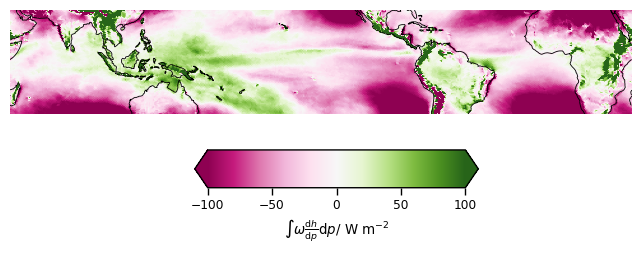

In [32]:
tropdmap(wdhdz_int_icon.mean('time'),cbar_title=r"$\int\omega\frac{\mathrm{d}h}{\mathrm{d}p}\mathrm{d}p$/ W m$^{-2}$",
         vmin=-100,vmax=100,cmap='PiYG')

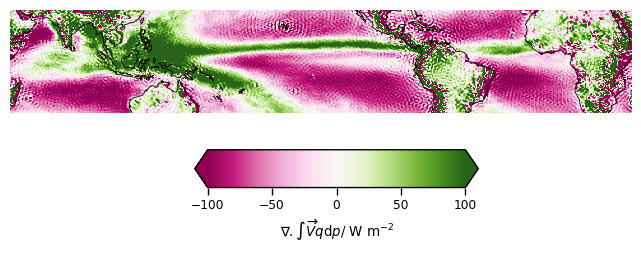

In [34]:
tropdmap(divqflux_int.mean('time')*Lv*-1,cbar_title=r"$\nabla.\int\overrightarrow{V}q\mathrm{d}p$/ W m$^{-2}$",
         vmin=-100,vmax=100,cmap='PiYG')

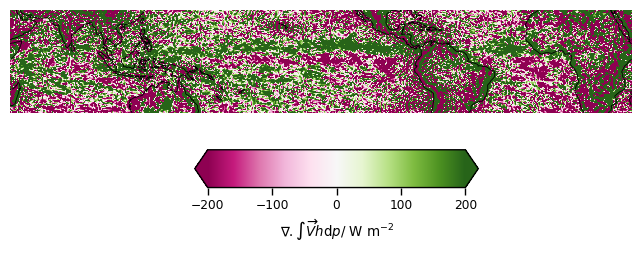

In [37]:
tropdmap(divmseflux_int.mean('time'),cbar_title=r"$\nabla.\int\overrightarrow{V}h\mathrm{d}p$/ W m$^{-2}$",
         vmin=-200,vmax=200,cmap='PiYG')

### $\Gamma$,$\Gamma_\mathrm{v}$

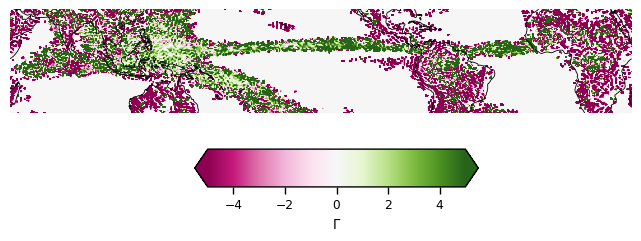

In [42]:
tropdmap(gamma_year.where(divqflux_int.mean('time')<0,0),
         cbar_title=r"$\Gamma$",vmin=-5,vmax=5,cmap='PiYG')

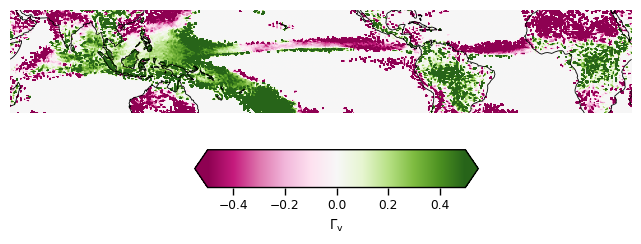

In [48]:
tropdmap(gamma_v_year.where(divqflux_int.mean('time')<0,0),
         cbar_title=r"$\Gamma_\mathrm{v}$",vmin=-0.5,vmax=0.5,cmap='PiYG')